<a href="https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation


In [23]:
# Installing required libraries
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
# Import the required python types for type hinting
# Turn off the notebook warnings

from typing import List, Tuple, Dict, Union, Callable, Iterable
import warnings

warnings.filterwarnings("ignore")

Next, we write a basic wrapper to make our code as deterministic as possible. As you probably know, deterministic programming will make most of our code generate the same outputs if it is run multiple times. In other words, random generators in a deterministic algorithm will create the same values every time they are called (which is why they are technically 'pseudorandom'). 

*   For more information about deterministic programming, read [here](https://www.geeksforgeeks.org/difference-between-deterministic-and-non-deterministic-algorithms/).  
*   For more information about wrappers in Python, read [here](https://www.geeksforgeeks.org/function-wrappers-in-python). 

If you look at the next cell, you will find steps that set up Python, PyTorch, and MONAI to work in a deterministic way. However, making an algorithm deterministic is more complicated than it seems, especially when coding in Google Colab. Google Colab is set up to assign you an actual graphic processing unit (GPU) every time you start a new session. Unfortunately, there is currently no way to make this assignment deterministic to the best of our knowledge. If hardware like the GPU is changed (particularly to a different type of GPU), results may be different, even if you use wrappers like what have here.


In [25]:
# Set random seeds for deterministic programming

import torch
import os
import numpy as np
import monai
import random
from functools import wraps


def make_determinate(func):
    """
    Makes a wrapper (decorator) for other functions to determine a specific
    seed for Pytorch, Moani, and Numpy and enable deterministic programming.
    """

    @wraps(func)
    def wrapper(*args, **kwargs):
        if "random_seed" in kwargs:
            random_seed = kwargs["random_seed"]
        else:
            random_seed = 1000
        np.random.seed(random_seed)
        os.environ["PYTHONHASHSEED"] = str(random_seed)
        random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        monai.utils.misc.set_determinism(seed=random_seed)
        return func(*args, **kwargs)

    return wrapper

In [26]:
# Selecting the processor device. Make sure your colab runtype is set to GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Data collection

Now that the environment is ready, we need to download some data to work on. For this chapter and the next one, we will work with a public Chest X-Ray (CXR) dataset that contains images for normal and pneumonia patients. The original dataset is found [here](https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded), but we already moved that data to a Google Drive location to speed up the download process. That is the source from where you will download the data in the following cell.

In [27]:
# Downloading the original data from a shortened version of the following link:
# https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/
# f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded.

# Remove "sample data" folder that colab always includes but we don't need it!
# Please be careful with the "rm -rf" command. If you accidentally run it or change the
# location it is pointing towards, you may remove important files from your
# notebook.
!rm -rf ./sample_data/
import gdown

if not os.path.isdir("chest_xray"):
    gdown.download(
        "https://drive.google.com/uc?export=download&confirm=pbef&id=1L8ox5fIwb_PijLcPEofQyhe3oGiYESO2",
        "chest_xray.zip",
        quiet=False,
    )
    !unzip -q chest_xray.zip

    os.remove("chest_xray.zip")

In [28]:
# Collecting all image paths, along with their associated labels and sets


def collect_imageinfo_list(images_dirpath: str) -> List:
    """
    Return a list of information tuples for all images, where each information
    tuple includes the associated path, label, and set for each image.
    Parameters:
      - images_dirpath (str): Path to the directory including all images.
      - imageinfo_list (List): a list of (file_path, file_label, file_set)
      for each image file.
    """
    imageinfo_list = list()
    for root, dirs, files in os.walk(images_dirpath):
        for file in files:
            if file.lower().endswith(".jpeg") or file.lower().endswith(".jpg"):
                file_path = os.path.join(root, file)
                dir_path = os.path.dirname(file_path)
                file_label = dir_path.split("/")[-1]
                file_set = os.path.dirname(dir_path).split("/")[-1]
                imageinfo_list.append((file_path, file_label, file_set))
    return imageinfo_list


imageinfo_list = collect_imageinfo_list("chest_xray")

train_imageinfo_list = [
    imageinfo for imageinfo in imageinfo_list if imageinfo[2] == "train"
]
train_pneumonia_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "PNEUMONIA"]
)
train_normal_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "NORMAL"]
)
test_imageinfo_list = [
    imageinfo for imageinfo in imageinfo_list if imageinfo[2] == "test"
]
test_pneumonia_count = len(
    [imageinfo for imageinfo in test_imageinfo_list if imageinfo[1] == "PNEUMONIA"]
)
test_normal_count = len(
    [imageinfo for imageinfo in test_imageinfo_list if imageinfo[1] == "NORMAL"]
)

print(
    f"Number of images in the training set: {len(train_imageinfo_list)} --> \
Pneumonia: {train_pneumonia_count} - Normal: {train_normal_count}"
)
print(
    f"Number of images in the test set: {len(test_imageinfo_list)} --> \
Pneumonia: {test_pneumonia_count} - Normal: {test_normal_count}"
)

Number of images in the training set: 5232 --> Pneumonia: 3883 - Normal: 1349
Number of images in the test set: 624 --> Pneumonia: 390 - Normal: 234


In [29]:
# Building datasets and dataloaders using MONAI

from monai.transforms import (
    LoadImageD,
    EnsureChannelFirstD,
    ResizeD,
    Compose,
    NormalizeIntensityD,
    RandRotateD,
    RandZoomD,
    AddChannelD,
    LambdaD,
    ToTensorD,
    RepeatChannelD,
    Rotate90d,
    SelectItemsd,
)
from monai.data import Dataset
from torch.utils.data import DataLoader


@make_determinate
def build_dataloaders(
    train_imageinfo_list: List = train_imageinfo_list,
    test_imageinfo_list: List = test_imageinfo_list,
    image_size: int = 224,
    augment_train_data: bool = False,
    fct_to_train: float = 1.0,
    fct_to_valid: float = 0.5,
) -> DataLoader:
    """
    Build and return train and test dataloaders.
    Parameters:
      - train_imageinfo_list (list): a list of (file_path, file_label, file_set)
      for each image file in the training set.
      - test_imageinfo_list (list): a list of (file_path, file_label, file_set)
      for each image file in the test set.
      - image_size (int): the output image size for the dataloader, which would be
      (image_size * image_size).
      - fct_to_train (float): fraction of training data to make available for
      building the training data loader.
      - fct_to_valid (float): fraction of the test data to use as the validation
      set (and not the test set).
      - train_loader (DataLoader): dataloader for the training set.
      - test_loader (DataLoader): dataloader for the test set.
    """

    def worker_init_fn(worker_id):
        np.random.seed(np.random.get_state()[1][0] + worker_id)

    label_dict = {"PNEUMONIA": 1, "NORMAL": 0}
    train_data_list = [
        {"image": imageinfo[0], "label": label_dict[imageinfo[1]]}
        for imageinfo in train_imageinfo_list
    ]
    test_data_list = [
        {"image": imageinfo[0], "label": label_dict[imageinfo[1]]}
        for imageinfo in test_imageinfo_list
    ]

    # Shuffling the data before fractioning it
    # Note: We assume that each datapoint in the test_data_list belongs to
    # a seprate patient.
    random.shuffle(train_data_list)
    random.shuffle(test_data_list)

    # Using fractions of data
    P_train_list = [x for x in train_data_list if x["label"] == 1]
    N_train_list = [x for x in train_data_list if x["label"] == 0]
    P_test_list = [x for x in test_data_list if x["label"] == 1]
    N_test_list = [x for x in test_data_list if x["label"] == 0]
    touse_train_data = (
        P_train_list[: int(len(P_train_list) * fct_to_train)]
        + N_train_list[: int(len(N_train_list) * fct_to_train)]
    )
    touse_valid_data = (
        P_test_list[: int(len(P_test_list) * fct_to_valid)]
        + N_test_list[: int(len(N_test_list) * fct_to_valid)]
    )
    touse_test_data = [x for x in test_data_list if x not in touse_valid_data]

    # Building MONAI transforms
    Aug_transforms = Compose(
        [
            LoadImageD(keys="image"),
            EnsureChannelFirstD(keys="image"),
            LambdaD(keys="image", func=lambda x: x[0, :, :] if x.ndim == 3 else x),
            AddChannelD(keys="image"),
            ResizeD(keys="image", spatial_size=(image_size, image_size)),
            NormalizeIntensityD(keys="image"),
            RandRotateD(keys="image", mode="bilinear", range_x=0.26, prob=0.5),
            RandZoomD(keys="image", mode="bilinear"),
            Rotate90d(keys="image", k=3, spatial_axes=(0, 1)),
            ToTensorD(keys=["image", "label"]),
            RepeatChannelD(keys="image", repeats=3),
            SelectItemsd(keys=["image", "label"]),
        ]
    )
    NoAug_transforms = Compose(
        [
            LoadImageD(keys="image"),
            EnsureChannelFirstD(keys="image"),
            LambdaD(keys="image", func=lambda x: x[0, :, :] if x.ndim == 3 else x),
            AddChannelD(keys="image"),
            ResizeD(keys="image", spatial_size=(image_size, image_size)),
            NormalizeIntensityD(keys="image"),
            Rotate90d(keys="image", k=3, spatial_axes=(0, 1)),
            ToTensorD(keys=["image", "label"]),
            RepeatChannelD(keys="image", repeats=3),
            SelectItemsd(keys=["image", "label"]),
        ]
    )

    # Building MONAI datasets
    if augment_train_data:
        train_dataset = Dataset(touse_train_data, transform=Aug_transforms)
    else:
        train_dataset = Dataset(touse_train_data, transform=NoAug_transforms)
    valid_dataset = Dataset(touse_valid_data, transform=NoAug_transforms)
    test_dataset = Dataset(touse_test_data, transform=NoAug_transforms)

    # Building MONAI dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=1,
        worker_init_fn=worker_init_fn,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=1,
        worker_init_fn=worker_init_fn,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=1,
        worker_init_fn=worker_init_fn,
    )
    return train_loader, valid_loader, test_loader


# Testing the shape and dtype for a sample batche from the training dataloader:

train_loader, valid_loader, test_loader = build_dataloaders()
sample_batch = next(iter((train_loader)))
print(f"batch['image'] shape: {sample_batch['image'].shape}")
print(f"batch['image'] dtype: {sample_batch['image'].dtype}")
print(f"batch['label'] shape: {sample_batch['label'].shape}")
print(f"batch['label'] dtype: {sample_batch['label'].dtype}")

batch['image'] shape: torch.Size([8, 3, 224, 224])
batch['image'] dtype: torch.float32
batch['label'] shape: torch.Size([8])
batch['label'] dtype: torch.int64


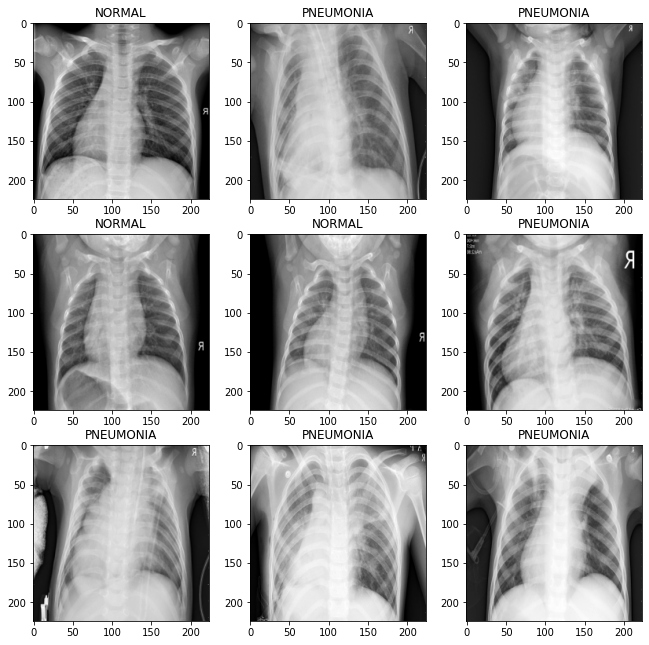

In [30]:
# Plotting sample images from the dataloaders.
from matplotlib import pyplot as plt

@make_determinate
def plot_sample_dataloader_images(dataloader):
    """
    Plot 9 sample images from either the training or test dataloaders.
    """
    label_tensor_dict = {1: "PNEUMONIA", 0: "NORMAL"}
    dataiter = iter(dataloader)
    image_tensor_list = list()
    label_list = list()
    fig, axes = plt.subplots(3, 3, figsize=(11, 11))
    for i in range(9):
        data = next(dataiter)
        image_batch, label_batch = data["image"], data["label"]
        axes[i // 3, i % 3].imshow(image_batch[0][0], cmap="gray")
        axes[i // 3, i % 3].set_title(label_tensor_dict[int(label_batch[0])])
    plt.show()


plot_sample_dataloader_images(train_loader)

In [31]:
# Building a resnet model

import torchvision.models as models
import torch.nn as nn
import shutil


@make_determinate
def build_model(arch: str = "vgg16", pretrained: bool = False) -> Callable:
    """
    Build a resnet model using Pytorch.
    Parameters:
      - arch (str): baseline architecture of the model that could be called using
      torchvision.models.arch command.
      - pretrained (bool): whether or not to use pretrained weights.
      - model (Callable): built pytorch module.
    """

    # Loading a model with the user-specified architecture from torch
    if "vgg" not in arch and "alexnet" not in arch and "resnet" not in arch:
        raise ValueError("Only resnet, vgg or alexnet models can be loaded!")
    else:
        try:
            model = eval(f"models.{arch}(pretrained={pretrained})")
        except:
            raise ValueError("The name of the architecture is not valid!")

    # Replacing the final fully conntected layer of the model
    # Please note that we have two classes, and therefore, the final FC layer
    # will have two final nodes
    # The VGG network has no FC layer, so we directly change its final layer
    if "vgg" in arch or "alexnet" in arch:
        model.classifier._modules["6"] = nn.Linear(4096, 2)
    else:
        num_in_features = model.fc.in_features
        model.fc = nn.Linear(num_in_features, 2)

    return model

In [32]:
# A function to evaluate a model's performance on the test_loader

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns


@make_determinate
def evaluate_model(
    model: Callable, test_loader: Iterable = test_loader, plot_cm: bool = True
) -> float:
    """
    Evaluate a given model's performance on the test set.
    Parameters:
      model (Callable): the pytorch model to be evaluated.
      test_loader (Iterable): test dataloader to be used as the test data.
      plot_cm (bool): whether or not to plot a confusion matrix.
      accuracy (float): accuracy of the model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    labels_list = list()
    preds_list = list()
    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = model(inputs)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            labels_list.append(labels)
            preds_list.append(preds)
        all_labels = torch.cat(labels_list).cpu()
        all_preds = torch.cat(preds_list).cpu()
        accuracy = (all_preds == all_labels).sum().item() / len(all_labels)

    if plot_cm:
        cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
        ax = plt.subplot()
        sns.heatmap(cm, annot=True, fmt="g", ax=ax)
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title(f"Confusion Matrix - accuracy: {accuracy:.2f}")
        ax.xaxis.set_ticklabels(["Pneumonia", "Normal"])
        ax.yaxis.set_ticklabels(["Pneumonia", "Normal"])

    return accuracy

In [33]:
def train_classifier(
    model: torch.nn.Module,
    model_name: str,
    train_loader: Iterable,
    valid_loader: Iterable,
    criterion: Callable,
    optimizer: torch.optim,
    num_epochs: int,
    plot_curves: bool,
):
    """
    Train a classifier model using pytorch and the given parameters.
    Parameters:
      model (Callable): any pytorch module,
      model_name (str): name of the model to be saved.
      train_loader (Iterable): dataloader for training data,
      valid_loader (Iterable): dataloader for validation data,
      criterion (Callable): any loss function,
      optimizer (torch.optim): a pytorch optimizer,
      num_epochs (int): number of epochs to train the model,
      plot_charts (bool): whether or not to plot the training and validation loss
      and accuracy curves.
    """

    # Sending the model to device (preferably GPU)
    model.to(device)

    # Releaseing the GPU memory. This is not necessary, but a good practice to do
    # before starting new training sessions.
    with torch.no_grad():
        torch.cuda.empty_cache()

    # Building a saving directory for models
    model_save_dir = os.path.join("Best_Models", model_name)
    if os.path.exists(model_save_dir):
        shutil.rmtree(model_save_dir)
    os.makedirs(model_save_dir, exist_ok=True)

    # lists to log the epoch values
    epoch_train_loss_list = list()
    epoch_train_accuracy_list = list()
    epoch_valid_loss_list = list()
    epoch_valid_accuracy_list = list()

    # Starting the training loop
    for epoch in range(1, num_epochs + 1):
        print("-" * 20, f"\nStarting epoch: {epoch}/{num_epochs}")

        ## training
        model.train()
        steps_train_loss = 0.0
        steps_correct_predictions = 0

        for batch in tqdm(train_loader, unit="batch"):
            inputs, labels = batch["image"].to(device), batch["label"].to(device)
            ### Zero the parameter gradients
            optimizer.zero_grad()

            ### Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            ### Accumulating the loss and number of correct predictions in step
            steps_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            steps_correct_predictions += (predicted == labels).sum().item()

        ## Measuring the epoch training loss and accuracy
        epoch_train_loss = steps_train_loss / len(train_loader)
        epoch_train_loss_list.append(epoch_train_loss)
        epoch_train_accuracy = steps_correct_predictions / len(train_loader.dataset)
        epoch_train_accuracy_list.append(epoch_train_accuracy)

        ## validation
        model.eval()
        steps_valid_loss = 0.0
        steps_correct_predictions = 0

        for batch in tqdm(valid_loader, unit="batch"):
            inputs, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            ### Accumulating the loss and number of correct predictions in step
            steps_valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            steps_correct_predictions += (predicted == labels).sum().item()

        ## Measuring the epoch validation loss and accuracy
        epoch_valid_loss = steps_valid_loss / len(valid_loader)
        epoch_valid_loss_list.append(epoch_valid_loss)
        epoch_valid_accuracy = steps_correct_predictions / len(valid_loader.dataset)
        epoch_valid_accuracy_list.append(epoch_valid_accuracy)

        ## Printing the logs
        print(
            f"train loss: {epoch_train_loss:.2f} | \
    train accuracy: {epoch_train_accuracy:.2f}"
        )
        print(
            f"valid loss: {epoch_valid_loss:.2f} | \
    valid accuracy: {epoch_valid_accuracy:.2f}"
        )

        ## Saving the best model
        if epoch == 1:
            best_valid_loss = epoch_valid_loss
            weight_name = f"{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth"
            torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
        elif epoch_valid_loss < best_valid_loss:
            weight_name = f"{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth"
            torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
            best_valid_loss = epoch_valid_loss

    # Printing the best model
    print(f"\nTrainng was over. The best model was: {weight_name}")

    # Plotting the loss and accuracy curves
    if plot_curves:
        epoch_train_loss_list.insert(0, 0)
        epoch_train_accuracy_list.insert(0, 0)
        epoch_valid_loss_list.insert(0, 0)
        epoch_valid_accuracy_list.insert(0, 0)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].plot(epoch_train_loss_list, color="blue", label="training")
        axes[0].plot(epoch_valid_loss_list, color="orange", label="validation")
        axes[0].set_xlim(1, len(epoch_valid_loss_list) + 1)
        axes[0].set_title("Loss curves")
        axes[0].legend()
        axes[1].plot(epoch_train_accuracy_list, color="blue", label="training")
        axes[1].plot(epoch_valid_accuracy_list, color="orange", label="validation")
        axes[1].set_xlim(1, len(epoch_train_accuracy_list) + 1)
        axes[1].set_title("Accuracy curves")
        axes[1].legend()

    # Loading the best weights and returning the model
    model.load_state_dict(torch.load(os.path.join(model_save_dir, weight_name)))
    return model

### Overfitting

Although underfitting may happen for the reasons mentioned above, the problem that is much more commonly seen during the training sessions is overfitting. As mentioned above, we always want to postpone overfitting as much as possible to give our model more time to learn from the data and improve its generalizability. Here, we will review four aspects of the training setup. Investigating and improving these may help with combatting overfitting. At the end of this section, we will deploy several of these strategies to run another round of training, with hopefully, more resistance to overfitting.

#### Training data size

It may look trivial, but we should mention that the most potent way for addressing overfitting is to add more data to your training. When your model sees more data during the training, it will have a more difficult job to memorize all data. Instead, it will have a higher chance of learning the patterns present in the data. As you can imagine, the problem with this solution is that finding more data is often not very feasible. 

---

>**Note**: If interested, build a data loader with only ten training samples from our pool of CXRs, and train a model on it. See for yourself how overfitting will show itself in the few starting steps of your training!

---

#### Data augmentation

Data augmentation is a well-known strategy to combat overfitting. Although this technique is never as effective as adding more unique training data, it will still help the training. The fundamental advantage of data augmentation is that the model will see variations of data points in each epoch. For example, a single photo may be used in a slightly rotated, horizontally or vertically flipped, zoomed in or out, or brighter or darker variations when the data loader calls it in each epoch.

Although the list of possible augmentations for imaging data is very long (and newer techniques are introduced every day), there are two challenges that data scientists should consider when augmenting medical images:

1.   The first issue is to decide about which augmentations to use. Not all augmentations may make sense for medical images, and some may make the model's job harder for no reason. For example, in our scenario for classifying CXRs, it does not make sense to augment the CXRs by vertical flipping. The reason is that CXRs would never be acquired upside-down!

2.   The second challenge is how much to augment. For example, it may make sense to rotate the CXRs for a few degrees to make the model think these CXRs are new data. However, if we rotate them as much as 90 degrees, we will be in the same situation as described above, where the augmentation has no value. Even if such limitations do not exist, estimating the benefit of augmentation is difficult. In fact, the types and amount of augmentation is another hyperparameter one needs to tune to achieve a good fit. 

---


>**Note**: As an exception to the above scenarios, if our CXR classifier is expected to see non-standard CXRs during the inference time (e.g., flipped or highly rotated ones), it may make sense to add such augmentations to our pipeline. Please note that augmenting the training data adds complexity to the model's data and makes the model fit more computationally demanding, so this complexity must have some returns (e.g., delayed overfitting). 


---
<br>

Recall that adding augmentation is often what we do when building our data loaders. So, let us build another data loader using augmentations and visualize their outputs below to see how much they differ from the outputs of the previous data loaders we used.

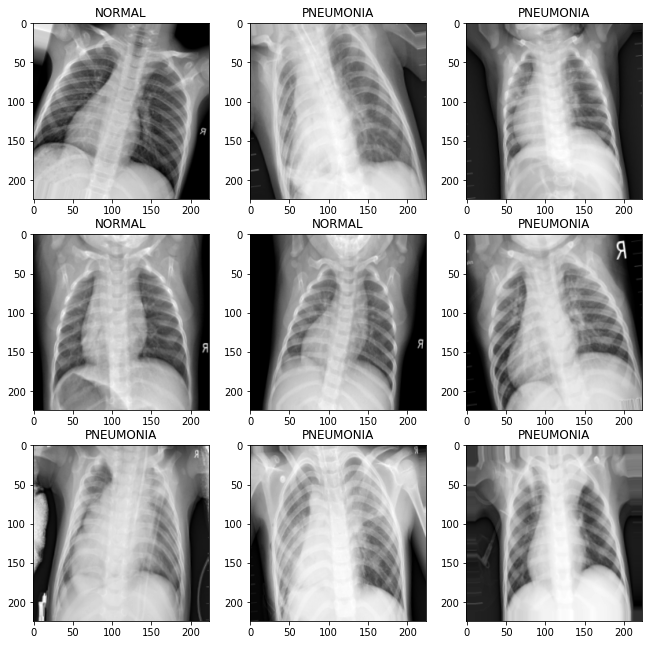

In [34]:
train_loader2, valid_loader2, test_loader2 = build_dataloaders(augment_train_data=True)
plot_sample_dataloader_images(train_loader2)

In [35]:
resnet18_model_1 = build_model(arch="resnet18", pretrained=False).cuda()
#summary(resnet18_model_1, input_size=(3, 224, 224))

As you can see, our ResNet 18 has about 11 million parameters, while our VGG16 had about 134 million! This is a huge difference! You will shortly be even more surprised when you see the performance of ResNet18 is also much better than the VGG. 

#### Transfer learning and fine-tuning

Last but not least, **transfer learning** is one of the best techniques to reduce overfitting. Not only does it help with a better fit, but it also reduces the dependency of training on training data. This means, with appropriate deployment of transfer learning, the model may learn the same or even better with a smaller fraction of data at hand. This is very useful in fields like medicine when adding more data is not always feasible. 

There are many ways to define transfer learning, but consider the analogy introduced at the beginning of this chapter. Remember that each deep learning model is a huge mathematical equation with many parameters. We told you that these parameters often begin with random values when the model is created. In transfer learning, these parameters are not randomly initiated anymore. Instead, they are imported from another model already trained to do a task similar to what we pursue. This source model is called a "pre-trained" model. 

Imagine our VGG16 model to classify the CXRs, and suppose we already have access to another VGG16 model that others have trained to differentiate viral pneumonia from COVID19 pneumonia. Although this second model is not exactly doing what we want to do, it is doing something similar, and perhaps, it will use many features that are similar to the features that our model should learn. In mathematical terms, many parameters of our model will probably end up having values close to values of the second model's parameters. Therefore, if one starts with this second model and starts to train that for the new purpose, training will probably be much faster and smoother than when training a randomly-initiated model from scratch. This process of just updating weights rather than training from random values is called **"fine-tuning."**

<br><img src="https://i.ibb.co/ck0tQt6/img16.png" alt="img16" border="0" height="500"><u><br><b>Figure 14.</b> Transfer learning vs. learning from scratch</u><br>Source: https://medium.datadriveninvestor.com/introducing-transfer-learning-as-your-next-engine-to-drive-future-innovations-5e81a15bb567
</br><br>

It is not always possible to find a model that does a 'similar task' but it is often the case that transfer learning from a model that is fairly different can still be better than starting from random values. The good news is that there are a number of pre-trained models (e.g. the ImageNet database) for a variety of purposes that can be very useful for transfer learning, and if you have limited data, it is valuable to start with one of those models. 

According to Wikipedia, The ImageNet project is a large visual database designed for use in visual object recognition software research. It consists of more than 14 million images of natural (not medical) objects that have been hand-annotated by the project to indicate what objects are pictured. As a tradition, whenever well-known deep learning models are introduced, developers pre-train them on ImageNet and release their weights. This means in the worst-case scenario, you can find access to the weights of a standard model that has been pre-trained on ImageNet to use in your project (unless you aim to use a custom architecture of your own or others). Although ImageNet is not a medical database, transfer learning from it to medical tasks is better than no transfer learning in many cases. The reason is that the ImageNet database is huge. Therefore, models pre-trained on that will have a memory of many features, at least some of which may be useful for medical training sessions as well. 

If you check the script for the "Build-model" function above, you can see that it loaded pre-trained weights from a model pre-trained on ImageNet to our VGG16 model. Do this now and see how an ImageNet pre-trained VGG16 will perform in evaluating our CXRs:

  0%|          | 0/39 [00:00<?, ?it/s]

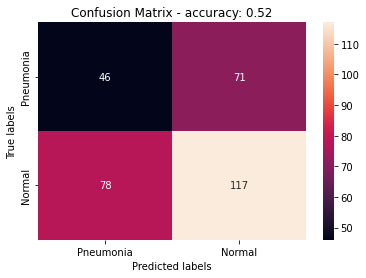

In [36]:
# Evaluating the performance of an ImageNet-pretrained model

Imagenet_pretrained_vgg16 = build_model(arch="vgg16", pretrained=True)
_ = evaluate_model(Imagenet_pretrained_vgg16)

This shows that the pre-trained model was not that successful in differentiating our CXRs from each other, but that should not be a surprise since that was not the ImageNet task. As said before, models pre-trained on ImageNet are trained to identify natural objects like animals, cars, etc. A model pre-trained on ImageNet will probably not do better on a medical imaging task than a randomly-initialized model. If we want to see the value of transfer learning, we must perform fine-tuning.

To emphasize again, fine-tuning means to start with a pre-trained model, freeze 'most' initial layers, and train the remaining layers (by 'freeze' we mean that the weights are not changed). The intuition behind this technique is that the initial layers of the models often learn low-level features (e.g., lines, edges, curves, circles, etc.). Subsequent layers recognize combinations of these (e.g. 2 lines at a 90 degree angle are a corner and 2 circles might represent eyes). As a result, in an ImageNet pre-trained model, we should mostly rely on the first two or three layers. Anything after those layers are likely specific to natural images and, therefore, not helpful in understanding medical images. Of course, if you happen to find a good medical imaging source model for your task, then feel free to use more later layers. 


---


> **Note:** This is the most basic form of fine-tuning. More advanced forms also exist, which are beyond the scope of this chapter. 


---

To see this in practice, load a ResNet18 model pre-trained on ImageNet, freeze its initial layers, and train it on our data. We will also use L2 regularization and data augmentation to focus resources to avoid overfitting and to improve performance.  

In [37]:
# Defining a function to freeze the resnet models for fine-tunning


def freeze_resnet18(
    resnet18_model: Callable,
    children_num_to_freeze: int = 5,
    print_children: bool = False,
):
    """
    Freeze a resnet18 model up to a user-specified children module.
    Parameters:
      resnet18_model: The resnet18 model to be frozen and returned.
      children_num_to_freeze: The number of children modules to be frozen.
      print_children (bool): Whether or not to print the children modules.
    """
    for i, child in enumerate(resnet18_model.children()):
        if i < children_num_to_freeze:
            status = "Frozen"
            for param in child.parameters():
                param.requires_grad = False
        else:
            status = "Unfrozen"
            for param in child.parameters():
                param.requires_grad = True
        if print_children:
            print(f"******************* child module number: {i} - {status}")
            print(child)
    return resnet18_model

In [38]:
# Creating a resnet18 model and freezing its inital layers.

resnet18_model = build_model(arch="resnet18", pretrained=True)
resnet18_model = freeze_resnet18(
    resnet18_model, children_num_to_freeze=5, print_children=False
)

In [39]:
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=learning_rate, weight_decay=0.001)
num_epochs = 5


In [ ]:
# baseline with no augmentation for resnet and vgg
resnet18_model = train_classifier(
    model=resnet18_model,
    model_name="Imagenet_pretrained_resnet18",
    train_loader=train_loader,  # no augmentation
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    plot_curves=True,
)

_ = evaluate_model(resnet18_model)

vgg_model = train_classifier(
    model=Imagenet_pretrained_vgg16,
    model_name="Imagenet_pretrained_vgg16",
    train_loader=train_loader2,
    valid_loader=valid_loader2,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    plot_curves=True,
)
_ = evaluate_model(vgg_model)

-------------------- 
Starting epoch: 1/5


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.05 |     train accuracy: 0.98
valid loss: 0.62 |     valid accuracy: 0.89
-------------------- 
Starting epoch: 2/5


  0%|          | 0/654 [00:00<?, ?batch/s]

-------------------- 
Starting epoch: 1/5


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.14 |     train accuracy: 0.95
valid loss: 0.49 |     valid accuracy: 0.90
-------------------- 
Starting epoch: 2/5


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.08 |     train accuracy: 0.97
valid loss: 1.08 |     valid accuracy: 0.79
-------------------- 
Starting epoch: 3/5


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.04 |     train accuracy: 0.99
valid loss: 0.86 |     valid accuracy: 0.86
-------------------- 
Starting epoch: 4/5


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.02 |     train accuracy: 0.99
valid loss: 0.94 |     valid accuracy: 0.82
-------------------- 
Starting epoch: 5/5


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.02 |     train accuracy: 0.99
valid loss: 1.15 |     valid accuracy: 0.83

Trainng was over. The best model was: resnet18_model_2_Epoch1_ACC=0.8974358974358975.pth


  0%|          | 0/39 [00:00<?, ?it/s]

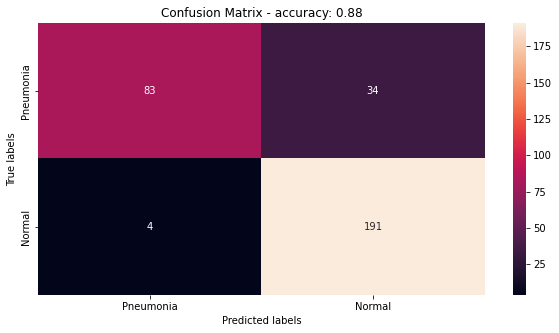

In [40]:
# Training a model with resnet18 architecture and pretrained weights


resnet18_model_2 = train_classifier(
    model=resnet18_model,
    model_name="resnet18_model_2",
    train_loader=train_loader2,  #augmented data
    valid_loader=valid_loader2,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    plot_curves=True,
)

_ = evaluate_model(resnet18_model)

-------------------- 
Starting epoch: 1/5


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.75 |     train accuracy: 0.49
valid loss: 0.69 |     valid accuracy: 0.56
-------------------- 
Starting epoch: 2/5


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.74 |     train accuracy: 0.50
valid loss: 0.69 |     valid accuracy: 0.56
-------------------- 
Starting epoch: 3/5


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.74 |     train accuracy: 0.50
valid loss: 0.69 |     valid accuracy: 0.56
-------------------- 
Starting epoch: 4/5


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.75 |     train accuracy: 0.49
valid loss: 0.69 |     valid accuracy: 0.56
-------------------- 
Starting epoch: 5/5


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.74 |     train accuracy: 0.50
valid loss: 0.69 |     valid accuracy: 0.56

Trainng was over. The best model was: Imagenet_pretrained_vgg16_Epoch1_ACC=0.5608974358974359.pth


  0%|          | 0/39 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f506d4a84c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


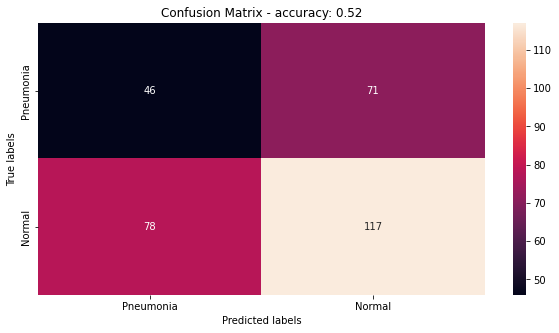

In [41]:


vgg_model_2 = train_classifier(
    model=Imagenet_pretrained_vgg16,
    model_name="Imagenet_pretrained_vgg16",
    train_loader=train_loader2,
    valid_loader=valid_loader2,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    plot_curves=True,
)
_ = evaluate_model(vgg_model_2)